In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import json
from json import JSONEncoder

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display


# ML
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

In [3]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata['length'] = metadata['end']-metadata['start']
metadata.info()
# metadata.describe()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   length           8732 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 614.1+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class,length
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


In [4]:
# Simple way to have a dict relating classID to class
class_dict = {}
for index, row in metadata.iterrows():
    class_dict[row['classID']]=row['class']
print(class_dict)
print(f'Number of unique classes: {len(class_dict)}')
class_list = [class_dict[i] for i in range(len(class_dict))]
print(class_list)

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
Number of unique classes: 10
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [5]:
features = pd.read_csv('large_data/engineered_features_full1.csv', index_col=0)

In [6]:
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8732 entries, 0 to 8731
Columns: 360 entries, roll_32.y_mw_zcr to roll_128.logbands_mw_20.19
dtypes: float64(360)
memory usage: 24.0 MB


,roll_32.y_mw_zcr,roll_32.y_mw_power_mcr,roll_32.spec_flatness.mean,roll_32.spec_flatness.median,roll_32.spec_flatness.std,roll_32.spec_flatness.iqr,roll_32.spec_flatness.max,roll_32.spec_flatness.min,roll_32.spec_flatness_mw.mean,roll_32.spec_flatness_mw.median,...,roll_128.logbands_mw_20.10,roll_128.logbands_mw_20.11,roll_128.logbands_mw_20.12,roll_128.logbands_mw_20.13,roll_128.logbands_mw_20.14,roll_128.logbands_mw_20.15,roll_128.logbands_mw_20.16,roll_128.logbands_mw_20.17,roll_128.logbands_mw_20.18,roll_128.logbands_mw_20.19
0,0.135986,0.0625,0.007302,0.006863,0.003682,0.002932,0.021535,0.000738,0.007529,0.006886,...,0.959228,0.956011,0.919508,0.901375,0.847516,0.760590,0.618048,0.434596,0.256670,0.0
1,0.194580,0.1875,0.011270,0.009636,0.006746,0.007716,0.054017,0.001534,0.009449,0.008758,...,0.957209,0.953224,0.930364,0.903451,0.876376,0.834565,0.748861,0.540045,0.328423,0.0
2,0.096436,0.3750,0.008501,0.007698,0.004740,0.005425,0.047758,0.001180,0.005622,0.005595,...,0.955252,0.962662,0.930562,0.892188,0.839806,0.793814,0.700622,0.483725,0.279222,0.0
3,0.184814,0.1250,0.020530,0.012416,0.025892,0.013284,0.175634,0.001876,0.082451,0.094452,...,0.956989,0.945573,0.914709,0.901231,0.852738,0.810400,0.728246,0.515547,0.349556,0.0
4,0.130859,0.3750,0.009634,0.008831,0.004951,0.005842,0.045587,0.001646,0.009653,0.009022,...,0.954739,0.950009,0.924492,0.908894,0.875890,0.816016,0.755140,0.531249,0.293928,0.0


In [7]:
features_f0 = pd.read_csv('large_data/engineered_features_f0_full1.csv', index_col=0)

In [8]:
features_f0 = features_f0.fillna(0)
features_f0.info()
features_f0.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8732 entries, 0 to 8731
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   range_low.f0_signal            8732 non-null   float64
 1   range_high.f0_stats.f0_mean    8732 non-null   float64
 2   range_high.f0_stats.f0_median  8732 non-null   float64
 3   range_high.f0_stats.f0_std     8732 non-null   float64
 4   range_high.f0_stats.f0_iqr     8732 non-null   float64
 5   range_high.f0_stats.f0_max     8732 non-null   float64
 6   range_high.f0_stats.f0_min     8732 non-null   float64
 7   range_high.f0_signal           8732 non-null   float64
 8   range_low.f0_stats.f0_mean     8732 non-null   float64
 9   range_low.f0_stats.f0_median   8732 non-null   float64
 10  range_low.f0_stats.f0_std      8732 non-null   float64
 11  range_low.f0_stats.f0_iqr      8732 non-null   float64
 12  range_low.f0_stats.f0_max      8732 non-null   f

,range_low.f0_signal,range_high.f0_stats.f0_mean,range_high.f0_stats.f0_median,range_high.f0_stats.f0_std,range_high.f0_stats.f0_iqr,range_high.f0_stats.f0_max,range_high.f0_stats.f0_min,range_high.f0_signal,range_low.f0_stats.f0_mean,range_low.f0_stats.f0_median,range_low.f0_stats.f0_std,range_low.f0_stats.f0_iqr,range_low.f0_stats.f0_max,range_low.f0_stats.f0_min
0,0.000000,551.190730,552.768807,4.497652,7.156487,557.576667,544.841599,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,2279.768303,2282.437616,170.241756,328.066133,2517.936841,2080.949703,0.109827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080925,1761.847747,1941.594727,405.183075,850.982713,2230.306669,1077.167118,0.294798,1128.712229,1115.153334,36.960305,57.225801,1195.191751,1077.167118
3,0.000000,552.046160,523.251131,41.031176,53.988435,666.915289,523.251131,0.260116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.040462,2128.539240,2129.589597,36.620152,49.205062,2191.991335,2057.047957,0.156069,66.850514,65.785287,1.875716,1.731598,70.915367,65.406391


In [9]:
features_m = pd.read_csv('./large_data/eq_harmony_combined.csv')
features_m.info()
features_m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   class             8732 non-null   object 
 1   eq_0              8732 non-null   float64
 2   eq_10             8732 non-null   float64
 3   eq_20             8732 non-null   float64
 4   eq_30             8732 non-null   float64
 5   eq_40             8732 non-null   float64
 6   eq_60             8732 non-null   float64
 7   eq_80             8732 non-null   float64
 8   eq_120            8732 non-null   float64
 9   eq_160            8732 non-null   float64
 10  eq_230            8732 non-null   float64
 11  eq_300            8732 non-null   float64
 12  eq_450            8732 non-null   float64
 13  eq_600            8732 non-null   float64
 14  eq_900            8732 non-null   float64
 15  eq_1200           8732 non-null   float64
 16  eq_1800           8732 non-null   float64


,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
0,children_playing,5.929216,5.157348,5.165380,5.563031,5.046141,5.564920,5.776320,6.222735,5.007891,...,0.808725,0.608560,0.552146,9.255638,1,0.000011,8.845374e-05,150.472464,4,5
1,children_playing,0.393928,0.369925,0.286040,0.234562,0.166241,0.137337,0.112779,0.137284,0.256864,...,5.756093,4.326530,3.608999,10.187929,1,0.002384,7.574148e-06,52.204787,2,10
2,street_music,3.980402,5.639204,8.452841,13.437525,19.415338,35.319351,61.852247,62.117064,69.794119,...,4.442734,3.375018,3.069331,7.897027,1,0.000030,6.712090e-05,332.313043,4,7
3,engine_idling,49.217855,118.563553,413.636333,356.165592,298.137279,250.708116,187.251374,154.515099,123.041750,...,7.791927,5.879618,5.338780,2.837097,1,0.013045,2.409356e-07,132.342029,16,10
4,jackhammer,32.283071,64.291137,87.047839,95.002994,83.547205,78.752242,62.357059,56.717538,47.499636,...,6.121235,4.655034,3.885653,7.351516,1,0.000003,7.250180e-07,77.518617,64,1


In [8]:
features_all = pd.concat([features, features_f0], axis=1)
features_all.info()
features_all.head()
meta_and_features = pd.concat([metadata, features_all], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8732 entries, 0 to 8731
Columns: 374 entries, roll_32.y_mw_zcr to range_low.f0_stats.f0_min
dtypes: float64(374)
memory usage: 25.0 MB


In [9]:
column_names = list(features_all)
for c in column_names:
    print(c)

roll_32.y_mw_zcr
roll_32.y_mw_power_mcr
roll_32.spec_flatness.mean
roll_32.spec_flatness.median
roll_32.spec_flatness.std
roll_32.spec_flatness.iqr
roll_32.spec_flatness.max
roll_32.spec_flatness.min
roll_32.spec_flatness_mw.mean
roll_32.spec_flatness_mw.median
roll_32.spec_flatness_mw.std
roll_32.spec_flatness_mw.iqr
roll_32.spec_flatness_mw.max
roll_32.spec_flatness_mw.min
roll_32.spec_centroid.mean
roll_32.spec_centroid.median
roll_32.spec_centroid.std
roll_32.spec_centroid.iqr
roll_32.spec_centroid.max
roll_32.spec_centroid.min
roll_32.spec_centroid_mw.mean
roll_32.spec_centroid_mw.median
roll_32.spec_centroid_mw.std
roll_32.spec_centroid_mw.iqr
roll_32.spec_centroid_mw.max
roll_32.spec_centroid_mw.min
roll_32.spec_bandwidth.mean
roll_32.spec_bandwidth.median
roll_32.spec_bandwidth.std
roll_32.spec_bandwidth.iqr
roll_32.spec_bandwidth.max
roll_32.spec_bandwidth.min
roll_32.spec_bandwidth_mw.mean
roll_32.spec_bandwidth_mw.median
roll_32.spec_bandwidth_mw.std
roll_32.spec_bandwidth_m

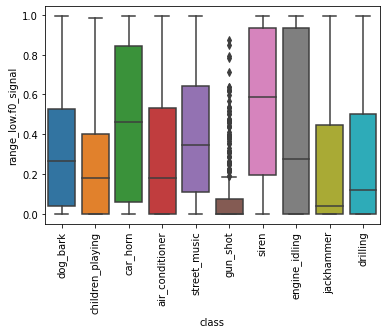

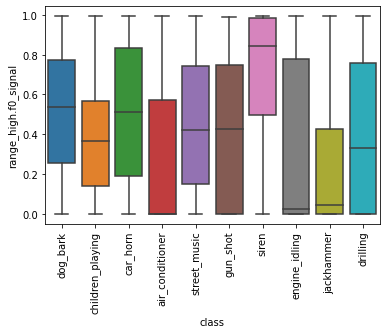

In [10]:
seaborn.boxplot(data=meta_and_features, x='class', y='range_low.f0_signal')
plt.xticks(rotation=90)
plt.show()
seaborn.boxplot(data=meta_and_features, x='class', y='range_high.f0_signal')
plt.xticks(rotation=90)
plt.show()

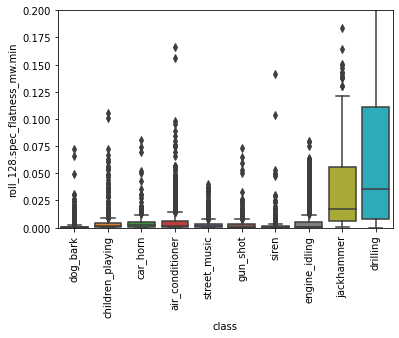

In [11]:
seaborn.boxplot(data=meta_and_features, x='class', y='roll_128.spec_flatness_mw.min')
plt.ylim([0,.2])
plt.xticks(rotation=90)
plt.show()

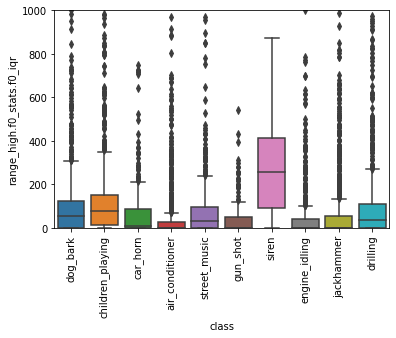

In [12]:
seaborn.boxplot(data=meta_and_features, x='class', y='range_high.f0_stats.f0_iqr')
plt.ylim([0,1000])
plt.xticks(rotation=90)
plt.show()

In [13]:
tmp = meta_and_features.groupby('class').mean()
tmp.info()
tmp['range_high.f0_signal']

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, air_conditioner to street_music
Columns: 381 entries, fsID to range_low.f0_stats.f0_min
dtypes: float64(381)
memory usage: 29.8+ KB


class
air_conditioner     0.264102
car_horn            0.504599
children_playing    0.371289
dog_bark            0.508044
drilling            0.397746
engine_idling       0.329655
gun_shot            0.410536
jackhammer          0.245598
siren               0.709041
street_music        0.443942
Name: range_high.f0_signal, dtype: float64

In [14]:
features_chosen = []

features_max_window = [
    'roll_128.y_mw_zcr',
    'roll_128.y_mw_power_mcr',
    'roll_128.spec_flatness_mw.min',
    'roll_128.spec_flatness_mw.max',
    'roll_128.spec_flatness_mw.median',
    'roll_128.spec_flatness_mw.iqr',
    'roll_128.spec_centroid_mw.min',
    'roll_128.spec_centroid_mw.max',
    'roll_128.spec_centroid_mw.median',
    'roll_128.spec_centroid_mw.iqr',
    'roll_128.spec_bandwidth_mw.min',
    'roll_128.spec_bandwidth_mw.max',
    'roll_128.spec_bandwidth_mw.median',
    'roll_128.spec_bandwidth_mw.iqr',
    'roll_128.spec_rolloff_mw.min',
    'roll_128.spec_rolloff_mw.max',
    'roll_128.spec_rolloff_mw.median',
    'roll_128.spec_rolloff_mw.iqr',
]

features_f0 = [
    'range_low.f0_signal',
    'range_high.f0_signal',
    'range_low.f0_stats.f0_median',
    'range_low.f0_stats.f0_iqr',
    'range_low.f0_stats.f0_max',
    'range_low.f0_stats.f0_min',
    'range_high.f0_stats.f0_median',
    'range_high.f0_stats.f0_iqr',
    'range_high.f0_stats.f0_max',
    'range_high.f0_stats.f0_min',
]

features_bands5 = [
    'roll_128.bands_mw_5.0',
    'roll_128.bands_mw_5.1',
    'roll_128.bands_mw_5.2',
    'roll_128.bands_mw_5.3',
    'roll_128.bands_mw_5.4',
]

features_bands10 = [
    'roll_128.bands_mw_10.0',
    'roll_128.bands_mw_10.1',
    'roll_128.bands_mw_10.2',
    'roll_128.bands_mw_10.3',
    'roll_128.bands_mw_10.4',
    'roll_128.bands_mw_10.5',
    'roll_128.bands_mw_10.6',
    'roll_128.bands_mw_10.7',
    'roll_128.bands_mw_10.8',
    'roll_128.bands_mw_10.9',
]

features_bands20 = [
    'roll_128.bands_mw_20.0',
    'roll_128.bands_mw_20.1',
    'roll_128.bands_mw_20.2',
    'roll_128.bands_mw_20.3',
    'roll_128.bands_mw_20.4',
    'roll_128.bands_mw_20.5',
    'roll_128.bands_mw_20.6',
    'roll_128.bands_mw_20.7',
    'roll_128.bands_mw_20.8',
    'roll_128.bands_mw_20.9',
    'roll_128.bands_mw_20.10',
    'roll_128.bands_mw_20.11',
    'roll_128.bands_mw_20.12',
    'roll_128.bands_mw_20.13',
    'roll_128.bands_mw_20.14',
    'roll_128.bands_mw_20.15',
    'roll_128.bands_mw_20.16',
    'roll_128.bands_mw_20.17',
    'roll_128.bands_mw_20.18',
    'roll_128.bands_mw_20.19',
]

features_chosen+=features_max_window+features_f0+features_bands20+features_bands10+features_bands5

In [49]:
model = RandomForestClassifier(n_jobs=4, n_estimators=30) # max_depth=15, n_estimators=500,
#model = make_pipeline(RobustScaler(), LogisticRegression(max_iter=1000))
#model = make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000,early_stopping=True))
#model = ExtraTreesClassifier() # n_estimators=500, max_depth=15
#model = AdaBoostClassifier(RandomForestClassifier(n_jobs=4)) # max_depth=15, n_estimators=500,

total_y_test = []
total_y_pred = []
total_y_pred_prob = []
total_y_pred_sorted = []

for validation_fold in range(1,11):
# for validation_fold in range(1,2):
    train_row = metadata['fold'] != validation_fold

    X_train = features_all.loc[train_row, features_chosen].values
    y_train = metadata.loc[train_row, 'classID'].values

    X_test = features_all.loc[~train_row, features_chosen].values
    y_test = metadata.loc[~train_row, 'classID']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = y_pred_prob[range(y_pred_prob.shape[0]),y_pred]
    
    y_pred_sorted = np.argsort(model.predict_proba(X_test), axis=1)
    #y_pred = y_pred_sorted[:,-best_n:]
    
    print(f'{validation_fold} {accuracy_score(y_pred,y_test)}')
    
    #total_y_test = np.concatenate(total_y_test, y_test)
    #total_y_pred = np.concatenate(total_y_pred, y_pred)
    total_y_test+=list(y_test)
    total_y_pred+=list(y_pred)
    total_y_pred_prob+=list(y_pred_prob)
    total_y_pred_sorted+=list(y_pred_sorted)

print(f'Total: {accuracy_score(total_y_pred,total_y_test)}')

total_y_test = np.array(total_y_test)
total_y_pred = np.array(total_y_pred)
total_y_pred_prob = np.array(total_y_pred_prob)
total_y_pred_sorted = np.array(total_y_pred_sorted)

1 0.5303550973654066
2 0.49099099099099097
3 0.5372972972972972
4 0.5282828282828282
5 0.5801282051282052
6 0.5394896719319563
7 0.5847255369928401
8 0.5136476426799007
9 0.5943627450980392
10 0.5878136200716846
Total: 0.5482134677049931


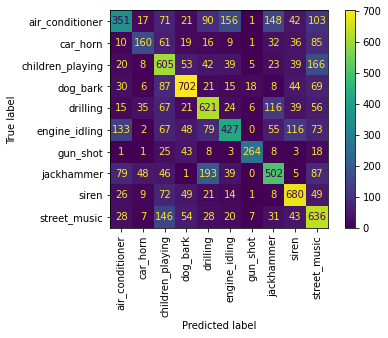

                  precision    recall  f1-score   support

 air_conditioner      0.506     0.351     0.415      1000
        car_horn      0.546     0.373     0.443       429
children_playing      0.485     0.605     0.538      1000
        dog_bark      0.694     0.702     0.698      1000
        drilling      0.555     0.621     0.586      1000
   engine_idling      0.572     0.427     0.489      1000
        gun_shot      0.871     0.706     0.780       374
      jackhammer      0.539     0.502     0.520      1000
           siren      0.649     0.732     0.688       929
    street_music      0.474     0.636     0.543      1000

        accuracy                          0.567      8732
       macro avg      0.589     0.565     0.570      8732
    weighted avg      0.571     0.567     0.562      8732



In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix(total_y_test,total_y_pred),display_labels=class_list)
disp.plot()
plt.xticks(rotation=90)
plt.show()

print(classification_report(total_y_test, total_y_pred, digits=3, target_names=class_list))

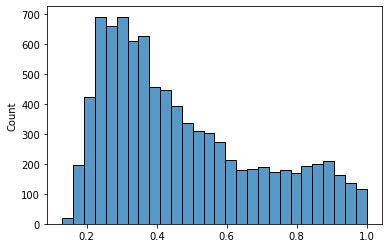

276

In [36]:
seaborn.histplot(total_y_pred_prob)
plt.show()
np.sum(total_y_pred_prob<.2)

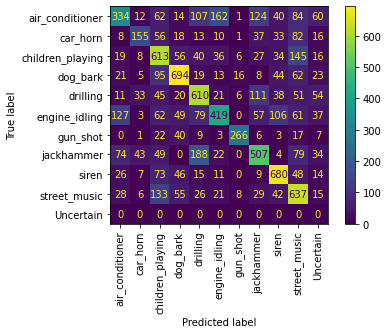

                  precision    recall  f1-score   support

 air_conditioner      0.515     0.334     0.405      1000
        car_horn      0.568     0.361     0.442       429
children_playing      0.507     0.613     0.555      1000
        dog_bark      0.700     0.694     0.697      1000
        drilling      0.552     0.610     0.579      1000
   engine_idling      0.584     0.419     0.488      1000
        gun_shot      0.875     0.711     0.785       374
      jackhammer      0.554     0.507     0.530      1000
           siren      0.664     0.732     0.696       929
    street_music      0.503     0.637     0.562      1000
       Uncertain      0.000     0.000     0.000         0

        accuracy                          0.563      8732
       macro avg      0.547     0.511     0.522      8732
    weighted avg      0.584     0.563     0.566      8732

0.03160787906550618


d:\code\python\erdosbootcamp\practice\practiceenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\python\erdosbootcamp\practice\practiceenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\python\erdosbootcamp\practice\practiceenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
class_list_soft = class_list.copy()
class_list_soft.append('Uncertain')

prob_thresh = .2

#kept_y_test = total_y_test[total_y_pred_prob>prob_thresh]
#kept_y_pred = total_y_pred[total_y_pred_prob>prob_thresh]

kept_y_test = total_y_test.copy()
kept_y_pred = total_y_pred.copy()
kept_y_pred[total_y_pred_prob<prob_thresh] = len(class_list_soft)

disp = ConfusionMatrixDisplay(confusion_matrix(kept_y_test,kept_y_pred),display_labels=class_list_soft)
disp.plot()
plt.xticks(rotation=90)
plt.show()

print(classification_report(kept_y_test, kept_y_pred, digits=3, target_names=class_list_soft))
print(np.sum(kept_y_pred==len(class_list_soft))/len(kept_y_pred))

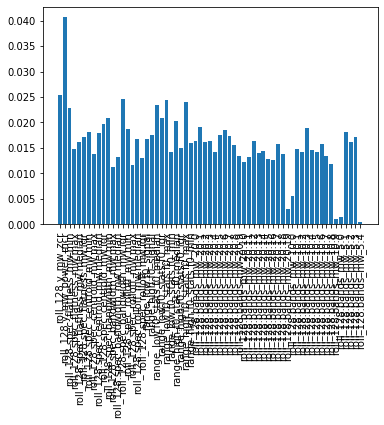

In [38]:
plt.bar(features_chosen,model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [39]:
y_pred_sorted[:,-1] - y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [59]:
best_n = 1

loose_classification = y_pred_sorted[:,-best_n:]
loose_match = [y_test.values[i] in loose_classification[i] for i in range(len(y_pred))]
print(np.sum(loose_match)/len(loose_match))

0.5830346475507766


In [65]:
target_class = 6 # gunshot is 6
best_n = 1

loose_classification = total_y_pred_sorted[:,-best_n:]

TP = 0
FP = 0
FN = 0
for i in range(len(total_y_test)):
    if total_y_test[i] == target_class:
        TP += target_class in loose_classification[i]
        FN += target_class not in loose_classification[i]
    else:
        FP += target_class in loose_classification[i]

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(f'{precision=}, {recall=}')

precision=0.8125, recall=0.6951871657754011
